In [1]:
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit, hessian, lax
from jax.example_libraries import optimizers
from jax.nn import relu
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata
%matplotlib inline

In [2]:
class DataGenerator(data.Dataset):
    def __init__(self, x, x1u, x1b, x2u, x2b, x3u, x3b,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.x = x  # input sample
        self.x1u = x1u
        self.x1b = x1b
        self.x2u = x2u
        self.x2b = x2b
        self.x3u = x3u
        self.x3b = x3b

        self.s3u1 = np.multiply(np.cos(x3u[:, 0] / 2 * np.pi), np.cos(x3u[:, 1] / 2 * np.pi))

        self.N = x.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        x, x1u, x1b, x2u, x2b, x3u, x3b, y = self.__data_generation(subkey)
        return x, x1u, x1b, x2u, x2b, x3u, x3b, y

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        x = self.x[idx, :]
        y = self.s3u1
        return x, x1u, x1b, x2u, x2b, x3u, x3b, y

In [3]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs[0]
  return init, apply


In [4]:
def Material(U_x, U_y, U_z, V_x, V_y, V_z, W_x, W_y, W_z,
             U_xx, U_xy, U_xz, U_yy, U_yz, U_zz,
             V_xx, V_xy, V_xz, V_yy, V_yz, V_zz,
             W_xx, W_xy, W_xz, W_yy, W_yz, W_zz, E=1.0, mu=0.25):

    ### Calculate the Lame constants
    la = E * mu / (1 + mu) / (1 - 2 * mu)
    G = E / (1 + mu) / 2

    ### Calculate strain
    e1 = U_x
    e2 = V_y
    e3 = W_z
    e12 = 0.5 * (U_y + V_x)
    e23 = 0.5 * (W_y + V_z)
    e13 = 0.5 * (U_z + W_x)

    ### Calculate stress
    s1 = (2 * G + la) * e1 + la * e2 + la * e3
    s2 = (2 * G + la) * e2 + la * e1 + la * e3
    s3 = (2 * G + la) * e3 + la * e1 + la * e2
    s12 = 2 * G * e12
    s23 = 2 * G * e23
    s13 = 2 * G * e13

    ### Calculate the residual from equilibrium equation
    Gex = (G + la) * (U_xx + V_xy + W_xz) + G * (U_xx + U_yy + U_zz)
    Gey = (G + la) * (V_yy + U_xy + W_yz) + G * (V_xx + V_yy + V_zz)
    Gez = (G + la) * (W_zz + U_xz + V_yz) + G * (W_xx + W_yy + W_zz)

    return e1, e2, e3, e12, e23, e13, s1, s2, s3, s12, s23, s13, Gex, Gey, Gez


# Define the model
class Multi_FNN:
    def __init__(self, layers):
        # Network initialization and evaluation functions
        self.u_layers_init, self.u_layers_apply = MLP(layers, activation=np.tanh)
        self.v_layers_init, self.v_layers_apply = MLP(layers, activation=np.tanh)
        self.w_layers_init, self.w_layers_apply = MLP(layers, activation=np.tanh)

        # Initialize
        u_layers_params = self.u_layers_init(rng_key=random.PRNGKey(1234))
        v_layers_params = self.v_layers_init(rng_key=random.PRNGKey(1234))
        w_layers_params = self.w_layers_init(rng_key=random.PRNGKey(1234))

        params = (u_layers_params, v_layers_params, w_layers_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
            self.opt_update, \
            self.get_params = optimizers.adam(optimizers.exponential_decay(1e-2,
                                                                           decay_steps=2000,
                                                                           decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    # Define DeepONet architecture
    def operator_net_u(self, params, a, b, c):
        u_layers_params, v_layers_params, w_layers_params = params
        inputs = np.stack([a, b, c], axis=-1)
        U = self.u_layers_apply(u_layers_params, inputs)
        return U*a

    def operator_net_v(self, params, a, b, c):
        u_layers_params, v_layers_params, w_layers_params = params
        inputs = np.stack([a, b, c], axis=-1)
        V = self.v_layers_apply(v_layers_params, inputs)
        return V*b

    def operator_net_w(self, params, a, b, c):
        u_layers_params, v_layers_params, w_layers_params = params
        inputs = np.stack([a, b, c], axis=-1)
        W = self.w_layers_apply(w_layers_params, inputs)
        return W*c

    # Define ODE/PDE residual
    def residual_net(self, params, a, b, c):
        u_x, u_y, u_z = grad(self.operator_net_u, argnums=(1, 2, 3))(params, a, b, c)
        u_xx, u_xy, u_xz = grad(grad(self.operator_net_u, argnums=1), argnums=(1, 2, 3))(params, a, b, c)
        u_yy, u_yz = grad(grad(self.operator_net_u, argnums=2), argnums=(2, 3))(params, a, b, c)
        u_zz = grad(grad(self.operator_net_u, argnums=3), argnums=3)(params, a, b, c)

        v_x, v_y, v_z = grad(self.operator_net_v, argnums=(1, 2, 3))(params, a, b, c)
        v_xx, v_xy, v_xz = grad(grad(self.operator_net_v, argnums=1), argnums=(1, 2, 3))(params, a, b, c)
        v_yy, v_yz = grad(grad(self.operator_net_v, argnums=2), argnums=(2, 3))(params, a, b, c)
        v_zz = grad(grad(self.operator_net_v, argnums=3), argnums=3)(params, a, b, c)

        w_x, w_y, w_z = grad(self.operator_net_w, argnums=(1, 2, 3))(params, a, b, c)
        w_xx, w_xy, w_xz = grad(grad(self.operator_net_w, argnums=1), argnums=(1, 2, 3))(params, a, b, c)
        w_yy, w_yz = grad(grad(self.operator_net_w, argnums=2), argnums=(2, 3))(params, a, b, c)
        w_zz = grad(grad(self.operator_net_w, argnums=3), argnums=3)(params, a, b, c)

        return u_x, u_y, u_z, u_xx, u_xy, u_xz, u_yy, u_yz, u_zz, \
            v_x, v_y, v_z, v_xx, v_xy, v_xz, v_yy, v_yz, v_zz, \
            w_x, w_y, w_z, w_xx, w_xy, w_xz, w_yy, w_yz, w_zz


    # Define residual loss
    def loss_res(self, params, batch):
        # Fetch data
        # inputs: (u1, y), shape = (Nxm, m), (Nxm,1)
        # outputs: u2, shape = (Nxm, 1)
        x, x1u, x1b, x2u, x2b, x3u, x3b, y = batch
        a, b, c = (x[:, i] for i in range(x.shape[-1]))
        # Compute forward pass
        U_x, U_y, U_z, U_xx, U_xy, U_xz, U_yy, U_yz, U_zz,\
        V_x, V_y, V_z, V_xx, V_xy, V_xz, V_yy, V_yz, V_zz,\
        W_x, W_y, W_z, W_xx, W_xy, W_xz, W_yy, W_yz, W_zz = vmap(self.residual_net, (None, 0, 0, 0))(params, a, b, c)
        a, b, c = (x1u[:, i] for i in range(x.shape[-1]))
        # Compute forward pass
        U_1u_x, U_1u_y, U_1u_z, U_1u_xx, U_1u_xy, U_1u_xz, U_1u_yy, U_1u_yz, U_1u_zz, \
            V_1u_x, V_1u_y, V_1u_z, V_1u_xx, V_1u_xy, V_1u_xz, V_1u_yy, V_1u_yz, V_1u_zz, \
            W_1u_x, W_1u_y, W_1u_z, W_1u_xx, W_1u_xy, W_1u_xz, W_1u_yy, W_1u_yz, W_1u_zz = vmap(self.residual_net, (None, 0, 0, 0))(params, a, b, c)
        a, b, c = (x1b[:, i] for i in range(x.shape[-1]))
        # Compute forward pass
        U_1b_x, U_1b_y, U_1b_z, U_1b_xx, U_1b_xy, U_1b_xz, U_1b_yy, U_1b_yz, U_1b_zz,\
        V_1b_x, V_1b_y, V_1b_z, V_1b_xx, V_1b_xy, V_1b_xz, V_1b_yy, V_1b_yz, V_1b_zz,\
        W_1b_x, W_1b_y, W_1b_z, W_1b_xx, W_1b_xy, W_1b_xz, W_1b_yy, W_1b_yz, W_1b_zz = vmap(self.residual_net, (None, 0, 0, 0))(params, a, b, c)
        a, b, c = (x2u[:, i] for i in range(x.shape[-1]))
        # Compute forward pass
        U_2u_x, U_2u_y, U_2u_z, U_2u_xx, U_2u_xy, U_2u_xz, U_2u_yy, U_2u_yz, U_2u_zz,\
        V_2u_x, V_2u_y, V_2u_z, V_2u_xx, V_2u_xy, V_2u_xz, V_2u_yy, V_2u_yz, V_2u_zz,\
        W_2u_x, W_2u_y, W_2u_z, W_2u_xx, W_2u_xy, W_2u_xz, W_2u_yy, W_2u_yz, W_2u_zz = vmap(self.residual_net, (None, 0, 0, 0))(params, a, b, c)
        a, b, c = (x2b[:, i] for i in range(x.shape[-1]))
        # Compute forward pass
        U_2b_x, U_2b_y, U_2b_z, U_2b_xx, U_2b_xy, U_2b_xz, U_2b_yy, U_2b_yz, U_2b_zz,\
        V_2b_x, V_2b_y, V_2b_z, V_2b_xx, V_2b_xy, V_2b_xz, V_2b_yy, V_2b_yz, V_2b_zz,\
        W_2b_x, W_2b_y, W_2b_z, W_2b_xx, W_2b_xy, W_2b_xz, W_2b_yy, W_2b_yz, W_2b_zz = vmap(self.residual_net, (None, 0, 0, 0))(params, a, b, c)
        a, b, c = (x3u[:, i] for i in range(x.shape[-1]))
        # Compute forward pass
        U_3u_x, U_3u_y, U_3u_z, U_3u_xx, U_3u_xy, U_3u_xz, U_3u_yy, U_3u_yz, U_3u_zz,\
        V_3u_x, V_3u_y, V_3u_z, V_3u_xx, V_3u_xy, V_3u_xz, V_3u_yy, V_3u_yz, V_3u_zz,\
        W_3u_x, W_3u_y, W_3u_z, W_3u_xx, W_3u_xy, W_3u_xz, W_3u_yy, W_3u_yz, W_3u_zz = vmap(self.residual_net, (None, 0, 0, 0))(params, a, b, c)
        a, b, c = (x3b[:, i] for i in range(x.shape[-1]))
        # Compute forward pass
        U_3b_x, U_3b_y, U_3b_z, U_3b_xx, U_3b_xy, U_3b_xz, U_3b_yy, U_3b_yz, U_3b_zz,\
        V_3b_x, V_3b_y, V_3b_z, V_3b_xx, V_3b_xy, V_3b_xz, V_3b_yy, V_3b_yz, V_3b_zz,\
        W_3b_x, W_3b_y, W_3b_z, W_3b_xx, W_3b_xy, W_3b_xz, W_3b_yy, W_3b_yz, W_3b_zz= vmap(self.residual_net, (None, 0, 0, 0))(params, a, b, c)

        ### Obtain the residuals from governing equation
        _, _, _, _, _, _, _, _, _, _, _, _, Gex, Gey, Gez = Material(
            U_x, U_y, U_z, V_x, V_y, V_z, W_x, W_y, W_z,
            U_xx, U_xy, U_xz, U_yy, U_yz, U_zz,
            V_xx, V_xy, V_xz, V_yy, V_yz, V_zz,
            W_xx, W_xy, W_xz, W_yy, W_yz, W_zz)
        
        ### Obtain the residuals from stress boundary conditions
        _, _, _, _, _, _, s11u, _, _, s121u, _, s131u, _, _, _ = Material(
            U_1u_x, U_1u_y, U_1u_z, V_1u_x, V_1u_y, V_1u_z, W_1u_x, W_1u_y, W_1u_z,
            U_1u_xx, U_1u_xy, U_1u_xz, U_1u_yy, U_1u_yz, U_1u_zz,
            V_1u_xx, V_1u_xy, V_1u_xz, V_1u_yy, V_1u_yz, V_1u_zz,
            W_1u_xx, W_1u_xy, W_1u_xz, W_1u_yy, W_1u_yz, W_1u_zz)

        _, _, _, _, _, _, _, _, _, s121b, _, s131b, _, _, _ = Material(
            U_1b_x, U_1b_y, U_1b_z, V_1b_x, V_1b_y, V_1b_z, W_1b_x, W_1b_y, W_1b_z,
            U_1b_xx, U_1b_xy, U_1b_xz, U_1b_yy, U_1b_yz, U_1b_zz,
            V_1b_xx, V_1b_xy, V_1b_xz, V_1b_yy, V_1b_yz, V_1b_zz,
            W_1b_xx, W_1b_xy, W_1b_xz, W_1b_yy, W_1b_yz, W_1b_zz)

        _, _, _, _, _, _, _, s22u, _, s122u, s232u, _, _, _, _ = Material(
            U_2u_x, U_2u_y, U_2u_z, V_2u_x, V_2u_y, V_2u_z, W_2u_x, W_2u_y, W_2u_z,
            U_2u_xx, U_2u_xy, U_2u_xz, U_2u_yy, U_2u_yz, U_2u_zz,
            V_2u_xx, V_2u_xy, V_2u_xz, V_2u_yy, V_2u_yz, V_2u_zz,
            W_2u_xx, W_2u_xy, W_2u_xz, W_2u_yy, W_2u_yz, W_2u_zz)

        _, _, _, _, _, _, _, _, _, s122b, s232b, _, _, _, _ = Material(
            U_2b_x, U_2b_y, U_2b_z, V_2b_x, V_2b_y, V_2b_z, W_2b_x, W_2b_y, W_2b_z,
            U_2b_xx, U_2b_xy, U_2b_xz, U_2b_yy, U_2b_yz, U_2b_zz,
            V_2b_xx, V_2b_xy, V_2b_xz, V_2b_yy, V_2b_yz, V_2b_zz,
            W_2b_xx, W_2b_xy, W_2b_xz, W_2b_yy, W_2b_yz, W_2b_zz)

        _, _, _, _, _, _, _, _, s33u, _, s233u, s133u, _, _, _ = Material(
            U_3u_x, U_3u_y, U_3u_z, V_3u_x, V_3u_y, V_3u_z, W_3u_x, W_3u_y, W_3u_z,
            U_3u_xx, U_3u_xy, U_3u_xz, U_3u_yy, U_3u_yz, U_3u_zz,
            V_3u_xx, V_3u_xy, V_3u_xz, V_3u_yy, V_3u_yz, V_3u_zz,
            W_3u_xx, W_3u_xy, W_3u_xz, W_3u_yy, W_3u_yz, W_3u_zz)

        _, _, _, _, _, _, _, _, _, _, s233b, s133b, _, _, _ = Material(
            U_3b_x, U_3b_y, U_3b_z, V_3b_x, V_3b_y, V_3b_z, W_3b_x, W_3b_y, W_3b_z,
            U_3b_xx, U_3b_xy, U_3b_xz, U_3b_yy, U_3b_yz, U_3b_zz,
            V_3b_xx, V_3b_xy, V_3b_xz, V_3b_yy, V_3b_yz, V_3b_zz,
            W_3b_xx, W_3b_xy, W_3b_xz, W_3b_yy, W_3b_yz, W_3b_zz)
        l1 = np.sum(np.square(Gex)) + np.sum(np.square(Gey)) + np.sum(np.square(Gez))

        lx = np.sum(np.square(s11u)) + np.sum(np.square(s121u)) + np.sum(np.square(s131u)) + np.sum(np.square(s121b)) + np.sum(np.square(s131b))
        ly = np.sum(np.square(s22u)) + np.sum(np.square(s122u)) + np.sum(np.square(s232u)) + np.sum(np.square(s122b)) + np.sum(np.square(s232b))
        lz = np.sum(np.square(s33u-y)) + np.sum(np.square(s233u)) + np.sum(np.square(s133u)) + np.sum(np.square(s233b)) + np.sum(np.square(s133b))
        l2 = lx + ly + lz

        # Compute loss
        loss = l1 + l2

        return l1, lx, ly, lz, loss

        # Define total loss

    def loss(self, params, res_batch):
        l1, lx, ly, lz, loss = self.loss_res(params, res_batch)
        return loss

        # Define a compiled update step

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, res_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, res_dataset, nIter=10000):
        # Define data iterators
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, res_batch)

            if it % 10 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                l1, lx, ly, lz, loss_value = self.loss_res(params, res_batch)
                # loss_res_value = self.loss_res(params, res_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_res_log.append(l1)

                # Print losses
                pbar.set_postfix({'Loss': loss_value,
                                  'l1': l1,
                                  'lx': lx,
                                 'ly': ly,
                                 'lz': lz})

    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, a, b, c):
        u_pred = vmap(self.operator_net_u, (None, 0, 0, 0))(params, a, b, c)
        v_pred = vmap(self.operator_net_v, (None, 0, 0, 0))(params, a, b, c)
        w_pred = vmap(self.operator_net_w, (None, 0, 0, 0))(params, a, b, c)
        return u_pred, v_pred, w_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, a, b, c):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, a, b, c)
        return r_pred


In [5]:
key = random.PRNGKey(0)

# initialize sample points' coordinates
C = scipy.io.loadmat('data/Coord.mat')
x = C['xy']
x1u = C['x1u']
x1b = C['x1b']
x2u = C['x2u']
x2b = C['x2b']
x3u = C['x3u']
x3b = C['x3b']
ns = C['n'][0, 0]
x, x1u, x1b, x2u, x2b, x3u, x3b = [np.array(i) for i in (x, x1u, x1b, x2u, x2b, x3u, x3b)]
# Create the PINN input list
batch_size = ns

res_dataset = DataGenerator(x, x1u, x1b, x2u, x2b, x3u, x3b, batch_size)
# Initialize model
layers = [3, 20, 20, 20, 20, 1]
model = Multi_FNN(layers)

In [6]:
C = scipy.io.loadmat('data/FEA.mat')
x = np.array(C['X'])
a, b, c = (x[:, i] for i in range(x.shape[-1]))
params = model.get_params(model.opt_state)
u, v, w = model.predict_s(params, a, b, c)


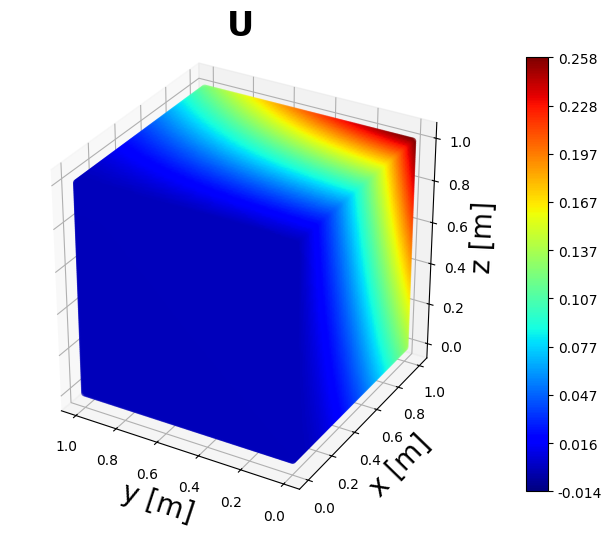

In [7]:
vmax = np.max(u)
vmin = np.min(u)
vlim = np.linspace(vmin, vmax, 10, endpoint=True)

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(projection='3d')
im = ax.scatter(x[:, 1], x[:, 0], x[:, 2], c=u, cmap='jet', vmin=vmin, vmax=vmax)
ax.set_xlabel('y [m]', fontsize=20)
ax.set_ylabel('x [m]', fontsize=20)
ax.set_zlabel('z [m]', fontsize=20)
ax.set_title('U', fontsize=24, fontweight='bold')
ax.set_box_aspect((np.ptp(x[:, 1]), np.ptp(x[:, 0]), np.ptp(x[:, 2])))
ax.invert_xaxis()
plt.colorbar(im, ticks=vlim, ax=ax, format='%.3f', fraction=0.02)

In [8]:
# Train
model.train(res_dataset, nIter=12000)

100%|██████████| 12000/12000 [44:29<00:00,  4.49it/s, Loss=11.460562, l1=10.386646, lx=0.19530857, ly=0.25604475, lz=0.6225621]  


In [9]:
C = scipy.io.loadmat('data/FEA.mat')
x = np.array(C['X'])
a, b, c = (x[:, i] for i in range(x.shape[-1]))

In [10]:
np.stack([a, b, c], axis=-1).shape

(522801, 3)

In [11]:
params = model.get_params(model.opt_state)
u, v, w = model.predict_s(params, a, b, c)

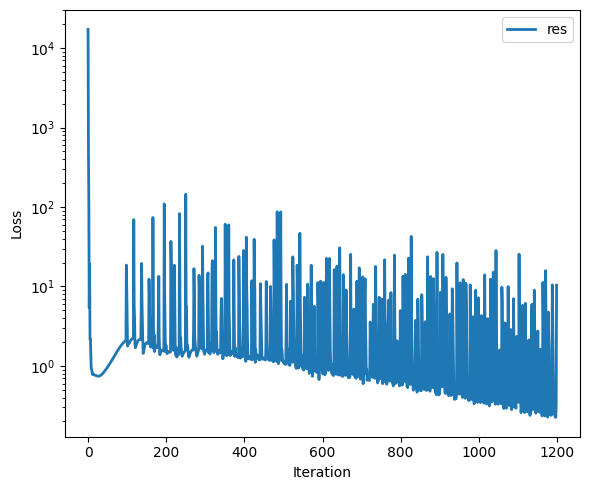

In [12]:
#Plot for loss function
plt.figure(figsize = (6,5))
plt.plot(model.loss_res_log, lw=2, label='res')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
U_x, U_y, U_z, U_xx, U_xy, U_xz, U_yy, U_yz, U_zz,\
        V_x, V_y, V_z, V_xx, V_xy, V_xz, V_yy, V_yz, V_zz,\
        W_x, W_y, W_z, W_xx, W_xy, W_xz, W_yy, W_yz, W_zz = vmap(model.residual_net, (None, 0, 0, 0))(params, a, b, c)
e1, e2, e3, e12, e23, e13, s1, s2, s3, s12, s23, s13, Gex, Gey, Gez = Material(
    U_x, U_y, U_z, V_x, V_y, V_z, W_x, W_y, W_z,
    U_xx, U_xy, U_xz, U_yy, U_yz, U_zz,
    V_xx, V_xy, V_xz, V_yy, V_yz, V_zz,
    W_xx, W_xy, W_xz, W_yy, W_yz, W_zz)

In [14]:
def plot_var(vc, x, title):
    vmax = np.max(vc)
    vmin = np.min(vc)
    vlim = np.linspace(vmin, vmax, 10, endpoint=True)
    
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(projection='3d')
    im = ax.scatter(x[:, 1], x[:, 0], x[:, 2], c=vc, cmap='jet', vmin=vmin, vmax=vmax)
    ax.set_xlabel('y [m]', fontsize=20)
    ax.set_ylabel('x [m]', fontsize=20)
    ax.set_zlabel('z [m]', fontsize=20)
    ax.set_title(title, fontsize=24, fontweight='bold')
    ax.set_box_aspect((np.ptp(x[:, 1]), np.ptp(x[:, 0]), np.ptp(x[:, 2])))
    ax.invert_xaxis()
    plt.colorbar(im, ticks=vlim, ax=ax, format='%.3f', fraction=0.02)

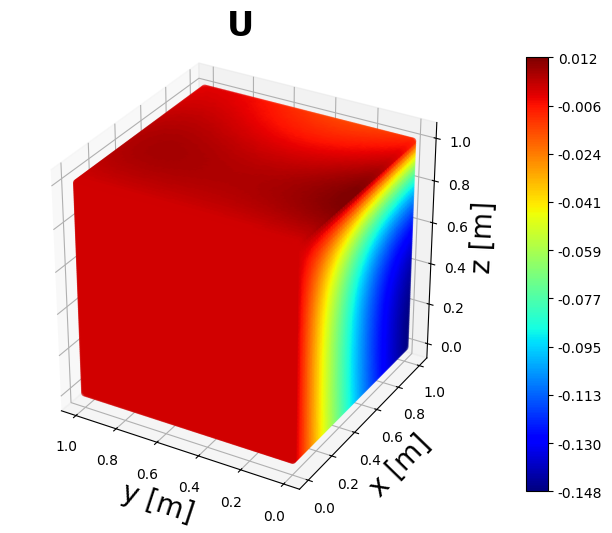

In [15]:
plot_var(u, x, 'U')

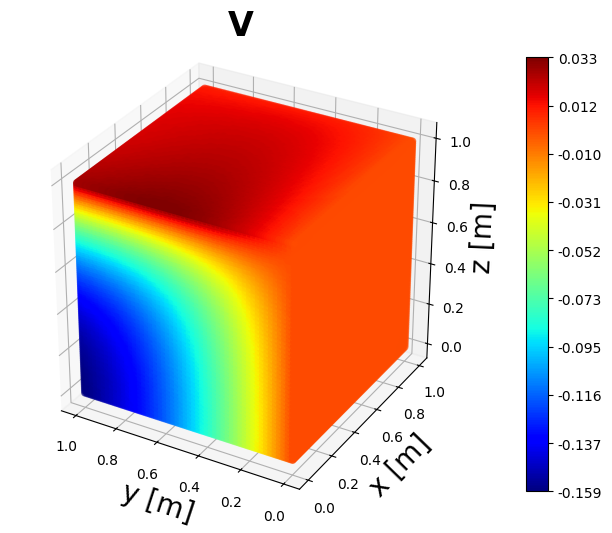

In [16]:
plot_var(v, x, 'V')

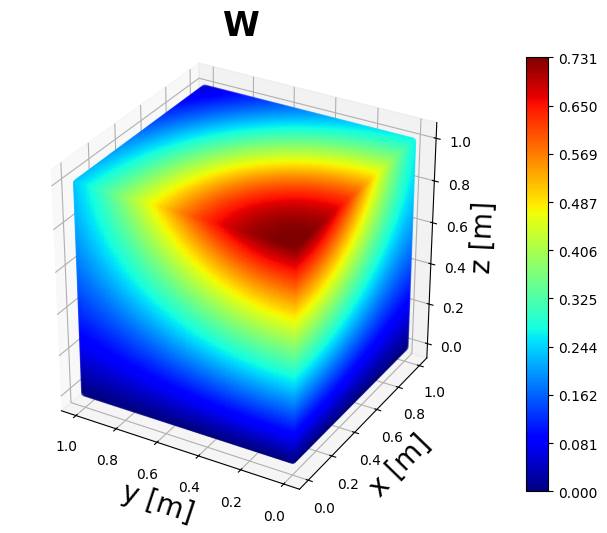

In [17]:
plot_var(w, x, 'W')

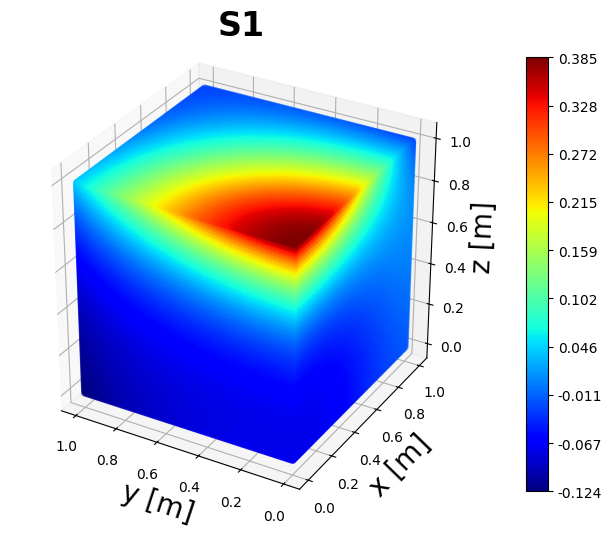

In [18]:
plot_var(s1, x, 'S1')

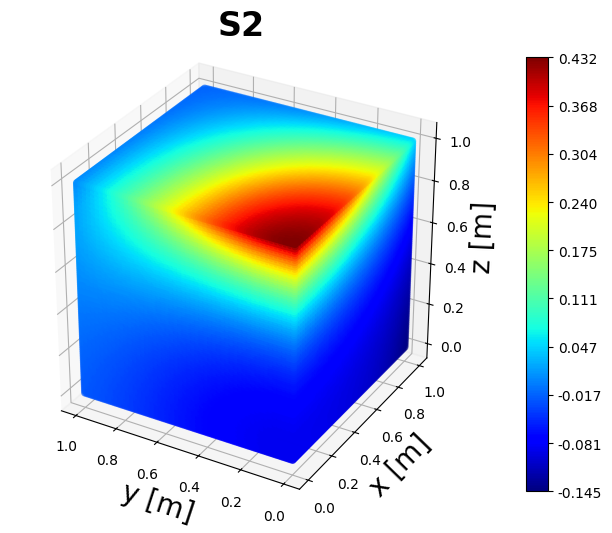

In [19]:
plot_var(s2, x, 'S2')

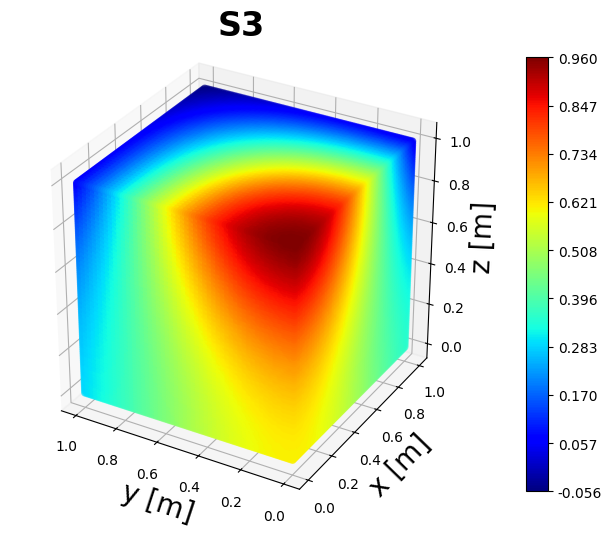

In [20]:
plot_var(s3, x, 'S3')

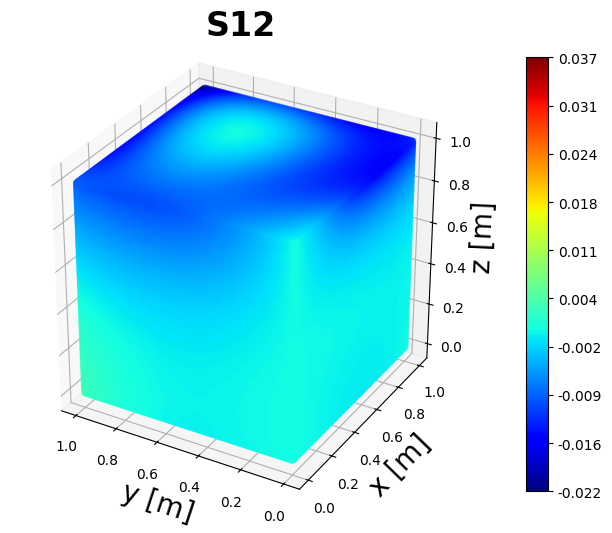

In [21]:
plot_var(s12, x, 'S12')

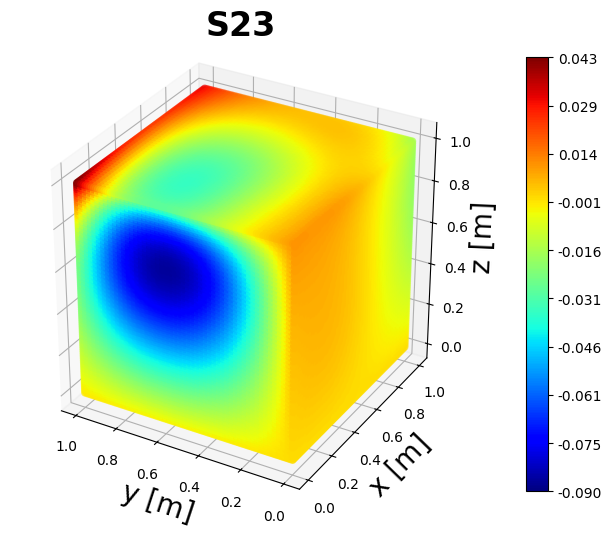

In [22]:
plot_var(s23, x, 'S23')

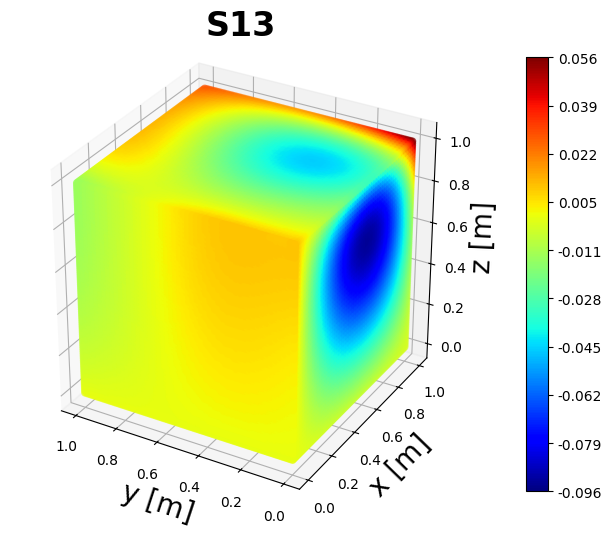

In [23]:
plot_var(s13, x, 'S13')